### Langgraph 基本概念
- state：状态，用于存储模型的中间状态和输出结果。
- node：节点，用于表示模型中的一个状态转换点。其实就是封装了业务逻辑的函数，它对流入其中的信息进行处理，并输出一个结果。
- edge：边，用于表示模型中的状态转换关系。其实就是一种根据上一个节点的输出，来决定选择哪一个节点作为下一个环节的函数。
- graph：图，用于表示模型的状态转换图。LangGraph之所以叫Graph，就是因为用它搭建的AI Agent的逻辑结构呈现为一种网状结构，这个网就是由大量的节点（Nodes），以及连接这些节点的边（Edge）组成的。
#### 1.状态 State
State是一种可以被Agent的所有节点共同使用的数据结构。
LangGraph中的State是由Schema和Reducer共同组成的。
- Schema：状态的结构定义，用于描述状态中包含的所有字段和它们的类型。
- Reducer：状态的更新函数，用于根据上一个节点的输出，来更新当前节点的状态，默认是覆盖。
在LangGraph中，State其实是一种字典，只不过为了保证相关运行数据类型的准确性，保证Agent的性能，LangGraph中一般用TypedDict来定义State。
```python
from typing import TypedDict

class AppState(TypedDict):
    char_class: str
    char_level: int
    char_HP: int
```
#### 2.节点 Node
Node，本质上就是函数，需要先定义出来，然后再加入到 Graph 中。
```python
import random

def dodge_check_node(state: AppState) -> AppState:
    """检查闪避结果并处理HP变化
        生成1-6的随机数，如果大于3则闪避成功，否则HP减少特定数值
    """
    dice_roll = random.randint(1, 6)
    if dice_roll > 3:
        print("你成功闪避了伤害")
    else:
        state['char_HP'] = state['char_HP'] - dice_roll
        print(f"闪避失败，受到{dice_roll}点伤害")
    return state

def display_character_status(state: AppState) -> AppState:
    """显示角色状态"""
    print("\n" + "="*30)
    print("      角色状态信息")
    print("="*30)
    print(f"职业：{state['char_class']}")
    print(f"等级：{state['char_level']}")
    print(f"当前HP：{state['char_HP']}")
    print("="*30)    
    return state
```
#### 3.创建编译Graph

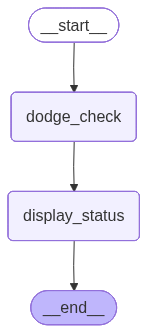

闪避失败，受到3点伤害

      角色状态信息
职业：法师
等级：1
当前HP：97


In [2]:
from langgraph.graph import StateGraph, START, END
from typing import TypedDict
from IPython.display import Image, display
import random


class AppState(TypedDict):
    char_class: str
    char_level: int
    char_HP: int


def dodge_check_node(state: AppState) -> AppState:
    """检查闪避结果并处理HP变化
    生成1-6的随机数，如果大于3则闪避成功，否则HP减少特定数值
    """
    dice_roll = random.randint(1, 6)
    if dice_roll > 3:
        print("你成功闪避了伤害")
    else:
        state["char_HP"] = state["char_HP"] - dice_roll
        print(f"闪避失败，受到{dice_roll}点伤害")
    return state


def display_character_status(state: AppState) -> AppState:
    """显示角色状态"""
    print("\n" + "=" * 30)
    print("      角色状态信息")
    print("=" * 30)
    print(f"职业：{state['char_class']}")
    print(f"等级：{state['char_level']}")
    print(f"当前HP：{state['char_HP']}")
    print("=" * 30)
    return state


# 激活 StateGraph
graph = StateGraph(AppState)
# 添加节点
graph.add_node("dodge_check", dodge_check_node)
graph.add_node("display_status", display_character_status)
# 连接节点
graph.add_edge(START, "dodge_check")
graph.add_edge("dodge_check", "display_status")
graph.add_edge("display_status", END)
# 编译 Graph
app = graph.compile()

# 可视化 Graph
display(Image(app.get_graph().draw_mermaid_png()))

result = app.invoke({"char_class": "法师", "char_level": 1, "char_HP": 100})
